In [82]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, auc, precision_recall_curve, accuracy_score, roc_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# Machine Learning for Covid Mortality

## Abstract
In this project, we aim to investigate the intricate relationship between different factors and the mortality rate of COVID-19 by employing a range of machine-learning techniques. Our objective is to develop predictive models that not only enhance our understanding of risk factors but also aid public health strategies in mitigating the impact of pandemic. 

## Group Members
- **Kai Luke Holton**
- **Thomas Shou**
- **Omobolade Odedoyin**
- **Dee Velazquez**

## Project Links
Access our complete project code and documentation [here on GitHub](https://github.com/shuyashou/cs475_final_project).

Access our pre-trained models [through web interface](https://cs475project-c17babadc414.herokuapp.com/).

## Introduction
The COVID-19 pandemic has presented unprecedented challenges across the globe, affecting various aspects of life and necessitating robust data analysis to understand and combat the virus effectively. Our project focuses on analyzing case data to predict trends and potential outbreaks using advanced machine learning techniques. This report details our methodologies, findings, and the implications of our work.

We structured our project into several key phases:
1. **Data Collection**: Gathering the latest COVID-19 mortality data from CDC.
2. **Data Cleaning and Preprocessing**: Ensuring data quality and readiness for analysis.
3. **Exploratory Data Analysis (EDA)**: Identifying trends and patterns from the data.
4. **Model Development and Evaluation**: Building and tuning models to predict future case counts and assessing the performance and reliability.
5. **Insights and Recommendations**: Drawing conclusions and providing actionable insights based on our models' outputs.

In the following sections, we delve into each of these areas, presenting our approaches, techniques used, and the outcomes of our analysis.


## Data Collection

### Data Source
Our project utilizes data from the [COVID-19 Case Surveillance Public Use Data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf/about_data), which is maintained by the Centers for Disease Control and Prevention (CDC). 

### Data Acquisition
We fetch their dataset from their public API, load it into pandas dataframe, drop rows with missing values, and save it as pickle file. The python source code can be access [here](https://github.com/shuyashou/cs475_final_project/blob/main/scripts/download.py).

### Data Dictionary
- `cdc_case_earliest_dt`: The earlier of the Clinical Date (date related to the illness or specimen collection) or the Date Received by CDC.
- `cdc_report_dt`: Date case was first reported to the CDC.
- `pos_spec_dt`: Date of first positive specimen collection.
- `onset_dt`: Symptom onset date.
- `current_status`: Case Status (Case Report Form: What is the current status of this person?)
- `sex`: Sex (Case Report Form)
- `age_group`: Age Groups
- `race_ethnicity_combined`: Race and ethnicity (combined).
- `hosp_yn`: Hospitalization status (Case Report Form: Was the patient hospitalized?)
- `icu_yn`: ICU admission status (Case Report Form: Was the patient admitted to an intensive care unit (ICU)?)
- `death_yn`: Death status (Case Report Form: Did the patient die as a result of this illness?)
- `medcond_yn`: Presence of underlying comorbidity or disease (Case Report Form: Pre-existing medical conditions?)

### Initial Observations
- The dataset contains 106 million rows and 12 columns, each row is a deidentified patient.
- The dataset contains lots of missing/unknown values. 


## Data Cleaning and Preprocessing

### Steps:
1. Drop any row with missing/unknown values. This reduces size of dataset from 106 M to 700 K. (This part handled in the previous data collection part.)
2. Get rid of all columns related to date/time.
3. One-hot encode all categorical variables and keep only one of any column with binary outcome after one-hot encoding. 


In [30]:
df = pd.read_pickle("./cdcdata.pkl")

In [31]:
def one_hot_encode_features(df, columns_to_encode):
    for column in columns_to_encode:
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame.")

    df_encoded = pd.get_dummies(df, columns=columns_to_encode)

    return df_encoded

columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No']

df_encoded = one_hot_encode_features(df, columns_to_encode)
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [32]:
df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18336515,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336519,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336523,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
18336525,True,False,True,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


The table displayed in the output consists of processed and encoded features ready for machine-learning model development.

Each row represents a de-identified patient record from the CDC dataset, and each column represents a feature derived from the original dataset's categorical variables. Each column now represents a category of the original feature, where a value of True (1) indicates the presence of that category, and False (0) indicates its absence.

Time-related columns (cdc_case_earliest_dt, cdc_report_dt, pos_spec_dt, onset_dt) and redundant negative indicators for binary outcomes (e.g., hosp_yn_No, icu_yn_No, death_yn_No, medcond_yn_No) have been removed to focus on relevant predictors for the mortality outcome.

The resulting dataset has been simplified to 25 columns, each indicating either a status (confirmed/probable case), demographic information (sex, age group, race/ethnicity), or a health-related condition (hospitalization, ICU admission, death, existing medical conditions).

This simplification aims to reduce the complexity of the model and focus on variables directly relevant to predicting outcomes.

## Exploratory Data Analysis (EDA)

### Imbalanced class label distribution

death_yn_Yes
False    701401
True      28786
Name: count, dtype: int64
death_yn_Yes
False    0.960577
True     0.039423
Name: count, dtype: float64


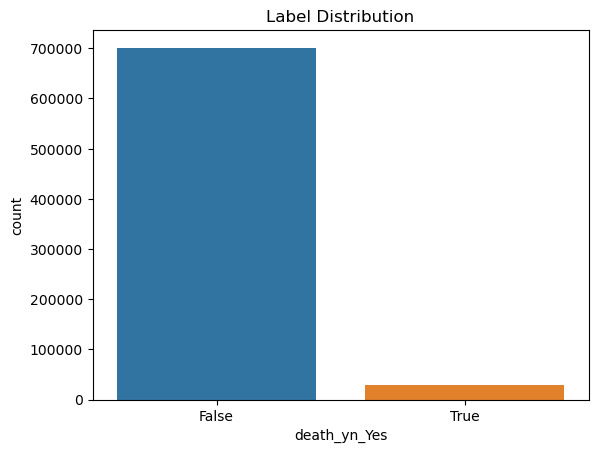

In [33]:
label_counts = df['death_yn_Yes'].value_counts() # death_yn_yes chose as ground truth label
print(label_counts)

label_proportions = label_counts / len(df)
print(label_proportions)


sns.countplot(x=df['death_yn_Yes'])
plt.title('Label Distribution')
plt.show()

The bar chart illustrates the label distribution for the death_yn_Yes feature in your dataset. It shows a significant class imbalance with the majority of cases labeled as 'False' (indicating survival) and a much smaller number labeled as 'True' (indicating death). 

## Model Development and Evaluation

### 1. Logistic Regression Model

In [34]:
features = df.drop('death_yn_Yes', axis=1) # death_yn_yes chose as ground truth label
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [35]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Model Architecture

In [8]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        logits = self.linear(x)
        probabilities = torch.sigmoid(logits) # Output a probability
        return probabilities

In [9]:
def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        
        for batch_features, batch_labels in train_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()  
            outputs = model(batch_features) 
            loss = loss_function(outputs.squeeze(), batch_labels.float())  
            loss.backward()  
            optimizer.step()  
            
            running_loss += loss.item() * batch_features.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Evaluation on the validation set
        val_accuracy = evaluate_model(model, val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    print("Training complete")


def evaluate_model(model, data_loader):
    model.eval()  
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  
        for batch_features, batch_labels in data_loader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_features) 
            predicted = torch.round(outputs.squeeze())
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)
    
    accuracy = correct_predictions / total_predictions
    return accuracy

#### Model Training

In [10]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")
    
# Hyperparameters    
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Using GPU: NVIDIA GeForce RTX 4080
Epoch 1/10, Loss: 0.0869, Validation Accuracy: 0.9668
Epoch 2/10, Loss: 0.0817, Validation Accuracy: 0.9663
Epoch 3/10, Loss: 0.0818, Validation Accuracy: 0.9667
Epoch 4/10, Loss: 0.0817, Validation Accuracy: 0.9664
Epoch 5/10, Loss: 0.0818, Validation Accuracy: 0.9668
Epoch 6/10, Loss: 0.0817, Validation Accuracy: 0.9665
Epoch 7/10, Loss: 0.0818, Validation Accuracy: 0.9666
Epoch 8/10, Loss: 0.0817, Validation Accuracy: 0.9667
Epoch 9/10, Loss: 0.0817, Validation Accuracy: 0.9668
Epoch 10/10, Loss: 0.0817, Validation Accuracy: 0.9667
Training complete
Test Accuracy: 0.9675


#### Model Evaluation Using Advanced Metrics
Since we have observed significant class label imbalance within our dataset, with over 96% belong to class 0 (no death), accuracy may not be good enough to truly reflect how well the model performs. Here we introduce ROC-AUC, precision and recall as additional evaluation metrics.

##### ROC-AUC
The ROC curve (Receiver Operating Characteristic curve) plots the true positive rate (recall) against the false positive rate at various threshold settings. The area under this curve (AUC) provides a single measure of a model's performance across all classification thresholds. A model that performs perfectly will have an AUC of 1.0, while a model that makes random guesses will have an AUC of 0.5.

In [11]:
def calculate_roc_score(model, test_loader):
    all_preds = []
    true_labels = []
    model.eval()  
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  

            outputs = model(inputs)

            all_preds.extend(outputs.squeeze().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    auc_roc_score = roc_auc_score(true_labels, all_preds)
    print(f"AUC-ROC Score: {auc_roc_score:.4f}")

In [12]:
calculate_roc_score(model, test_loader)

AUC-ROC Score: 0.9654


##### PR-AUC
The AUC of the Precision-Recall Curve is typically used to evaluate models on imbalanced datasets where the positive class (the minority class) is of greater interest. A score closer to 1.0 is ideal. Scores closer to 0.5 may not be much better than a random classifier.

In [13]:
def calculate_precision_recall_score(model, test_loader):
    all_preds = []
    true_labels = []
    model.eval()  
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  
            
            outputs = model(inputs)

            probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy()
            all_preds.extend(probabilities)
            true_labels.extend(labels.cpu().numpy())

    precision, recall, _ = precision_recall_curve(true_labels, all_preds)
    auc_pr = auc(recall, precision)
    print(f"Precision-Recall AUC: {auc_pr:.4f}")

In [14]:
calculate_precision_recall_score(model, test_loader)

Precision-Recall AUC: 0.5341


#### 1. Customize Loss Function

Since our model got a low PR AUC score, suggesting the model's discriminative ability has great room for improvement. We want to try replacing the originally used BCELoss function with a customized loss function, with
- weighting mechanism
- additional penalty term for misclassifying minority class instances as majority

In [15]:
def calculate_class_weights(labels):
    class_counts = torch.bincount(labels.long())
    weights = 1. / class_counts.float()
    weights = weights / weights.min()
    return weights

class WeightedBCELoss(torch.nn.Module):
    def __init__(self, weights, penalty_factor=2.0):
        super(WeightedBCELoss, self).__init__()
        self.weights = weights
        self.penalty_factor = penalty_factor

    def forward(self, outputs, targets):
        weights = self.weights.to(outputs.device)
        bce_loss = F.binary_cross_entropy_with_logits(outputs, targets, reduction='none')
        weighted_loss = bce_loss * weights[targets.long()]
        probabilities = torch.sigmoid(outputs)
        predicted_classes = probabilities > 0.5 

        false_negatives = (predicted_classes == 0) & (targets == 1)

        penalties = torch.zeros_like(weighted_loss)
        penalties[false_negatives] = weighted_loss[false_negatives] * self.penalty_factor

        total_loss = weighted_loss + penalties
        return total_loss.mean()

In [16]:
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

class_weights = calculate_class_weights(y_train_tensor)
loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
calculate_roc_score(model, test_loader)
calculate_precision_recall_score(model, test_loader)

Epoch 1/10, Loss: 1.0667, Validation Accuracy: 0.9126
Epoch 2/10, Loss: 1.0524, Validation Accuracy: 0.9082
Epoch 3/10, Loss: 1.0518, Validation Accuracy: 0.9069
Epoch 4/10, Loss: 1.0522, Validation Accuracy: 0.9084
Epoch 5/10, Loss: 1.0536, Validation Accuracy: 0.9085
Epoch 6/10, Loss: 1.0539, Validation Accuracy: 0.9108
Epoch 7/10, Loss: 1.0549, Validation Accuracy: 0.9120
Epoch 8/10, Loss: 1.0552, Validation Accuracy: 0.9078
Epoch 9/10, Loss: 1.0561, Validation Accuracy: 0.9105
Epoch 10/10, Loss: 1.0570, Validation Accuracy: 0.9012
Training complete
Test Accuracy: 0.9008
AUC-ROC Score: 0.9654
Precision-Recall AUC: 0.5982


#### 2. Balance the class size
The second way we tried to mitigate the negative effect of imbalanced class size is to reduce size of majority class. We randomly sampled a portion of class 0 (no death), and concatenate it with class 1. 
The resulting dataset has a much smaller size.

In [17]:
false_data = df[df['death_yn_Yes'] == 0]  # Majority class
true_data = df[df['death_yn_Yes'] == 1]   # Minority class
undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [18]:
balanced_df

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
17853,True,False,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,True
44490,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,False
37735,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
273,False,True,False,True,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
15598,True,False,True,False,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
38158,True,False,False,True,False,False,False,False,True,False,...,False,True,False,False,False,False,True,True,True,True
860,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
15795,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False


In [19]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Use a smaller batch size for smaller dataset

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
input_size = 24
model = LogisticRegressionModel(input_size)
model = model.to(device)

class_weights = calculate_class_weights(y_train_tensor)
loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
calculate_roc_score(model, test_loader)
calculate_precision_recall_score(model, test_loader)

Epoch 1/10, Loss: 0.5772, Validation Accuracy: 0.9198
Epoch 2/10, Loss: 0.5535, Validation Accuracy: 0.9179
Epoch 3/10, Loss: 0.5509, Validation Accuracy: 0.9177
Epoch 4/10, Loss: 0.5498, Validation Accuracy: 0.9175
Epoch 5/10, Loss: 0.5492, Validation Accuracy: 0.9185
Epoch 6/10, Loss: 0.5489, Validation Accuracy: 0.9189
Epoch 7/10, Loss: 0.5486, Validation Accuracy: 0.9184
Epoch 8/10, Loss: 0.5484, Validation Accuracy: 0.9184
Epoch 9/10, Loss: 0.5482, Validation Accuracy: 0.9184
Epoch 10/10, Loss: 0.5481, Validation Accuracy: 0.9196
Training complete
Test Accuracy: 0.9060
AUC-ROC Score: 0.9618
Precision-Recall AUC: 0.9500


#### 3. Feature Importance Measurement and Ablation


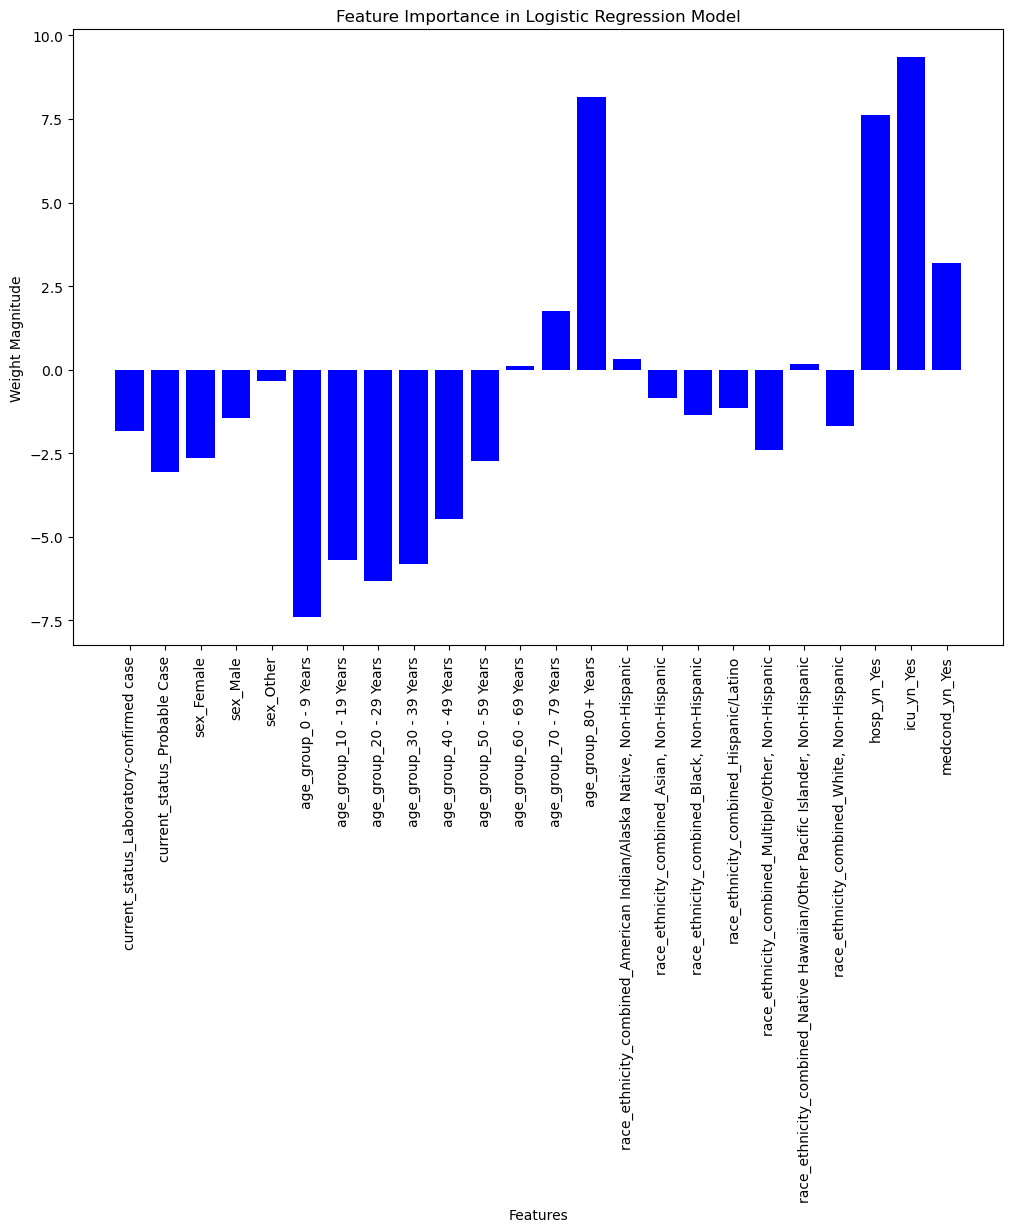

In [21]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'icu_yn_Yes', 'medcond_yn_Yes']
weights = model.linear.weight.data.cpu().numpy().flatten()
bias = model.linear.bias.data.cpu().numpy() 
    
plt.figure(figsize=(12, 8))
plt.bar(feature_names, weights, color='b')
plt.xlabel('Features')
plt.ylabel('Weight Magnitude')
plt.title('Feature Importance in Logistic Regression Model')
plt.xticks(rotation=90)
plt.show()

##### Re-train the model with icu condition feature being removed

In [22]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

false_data = df[df['death_yn_Yes'] == 0]  # Majority class
true_data = df[df['death_yn_Yes'] == 1]   # Minority class
undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [23]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64 # Use a smaller batch size for smaller dataset

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
input_size = 23
model = LogisticRegressionModel(input_size)
model = model.to(device)

class_weights = calculate_class_weights(y_train_tensor)
loss_function = WeightedBCELoss(weights=class_weights, penalty_factor=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=10)

test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')
calculate_roc_score(model, test_loader)
calculate_precision_recall_score(model, test_loader)

Epoch 1/10, Loss: 0.5934, Validation Accuracy: 0.9102
Epoch 2/10, Loss: 0.5621, Validation Accuracy: 0.9140
Epoch 3/10, Loss: 0.5579, Validation Accuracy: 0.9161
Epoch 4/10, Loss: 0.5563, Validation Accuracy: 0.9161
Epoch 5/10, Loss: 0.5554, Validation Accuracy: 0.9170
Epoch 6/10, Loss: 0.5550, Validation Accuracy: 0.9165
Epoch 7/10, Loss: 0.5546, Validation Accuracy: 0.9166
Epoch 8/10, Loss: 0.5544, Validation Accuracy: 0.9156
Epoch 9/10, Loss: 0.5542, Validation Accuracy: 0.9166
Epoch 10/10, Loss: 0.5541, Validation Accuracy: 0.9166
Training complete
Test Accuracy: 0.9038
AUC-ROC Score: 0.9478
Precision-Recall AUC: 0.9191


### 2. Random Forest Model
#### Model Architecture
We use pre-defined RandomForest Classifier in [sklearn library](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


#### Model Training

In [42]:
# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

# Fit the model on training data
rf_classifier.fit(X_train_tensor, y_train_tensor)

# Predict on validation data
y_pred_val = rf_classifier.predict(X_val_tensor)

# Predict on testing data
y_pred_test = rf_classifier.predict(X_test_tensor)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

Validation Accuracy: 0.9668031608211561
Testing Accuracy: 0.967843985811912


Our validation and testing accuracy are quite high which indicates great performance so far when it comes to our validation and testing set. However, we need to anaylze further to study how our model classifies data and how generalizable our model is.

#### Model Evaluation using advanced metrics

In [44]:
#Function to plot ROC Curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print("ROC-AUC: ", roc_auc)

#Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    print("PR-AUC: ", average_precision)
    
#Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [51]:
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test)

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test)

ROC-AUC:  0.9637102475396839
PR-AUC:  0.5292559209863967


The Receiver Operating Characteristic Area Under the Curve (ROC-AUC) value of 0.9637 suggests that the model's ability to distinguish between the positive and negative classes is high, with a score close to 1 indicating excellent performance.

In this case, a PR-AUC of 0.5293 suggests moderate performance in terms of precision and recall, but it may indicate a need for further investigation, especially if the imbalance between positive and negative classes is significant.

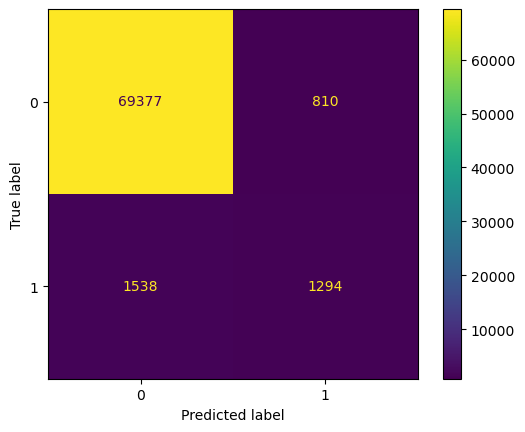

In [56]:
plot_confusion_matrix(y_test, y_pred_test)

- The high number of True Negatives (69377) suggests that the model is performing well at identifying instances of the negative class when they are truly negative.
- The relatively low number of False Negatives (810) indicates that the model occasionally misses instances of the positive class when they are truly positive.
- The number of True Positives (1294) suggests that the model is reasonably successful at identifying instances of the positive class when they are truly positive.
- The number of False Positives (1538) indicates that the model sometimes misclassifies instances of the negative class as positive.

#### 1. Feature Importance Measurement and Ablation

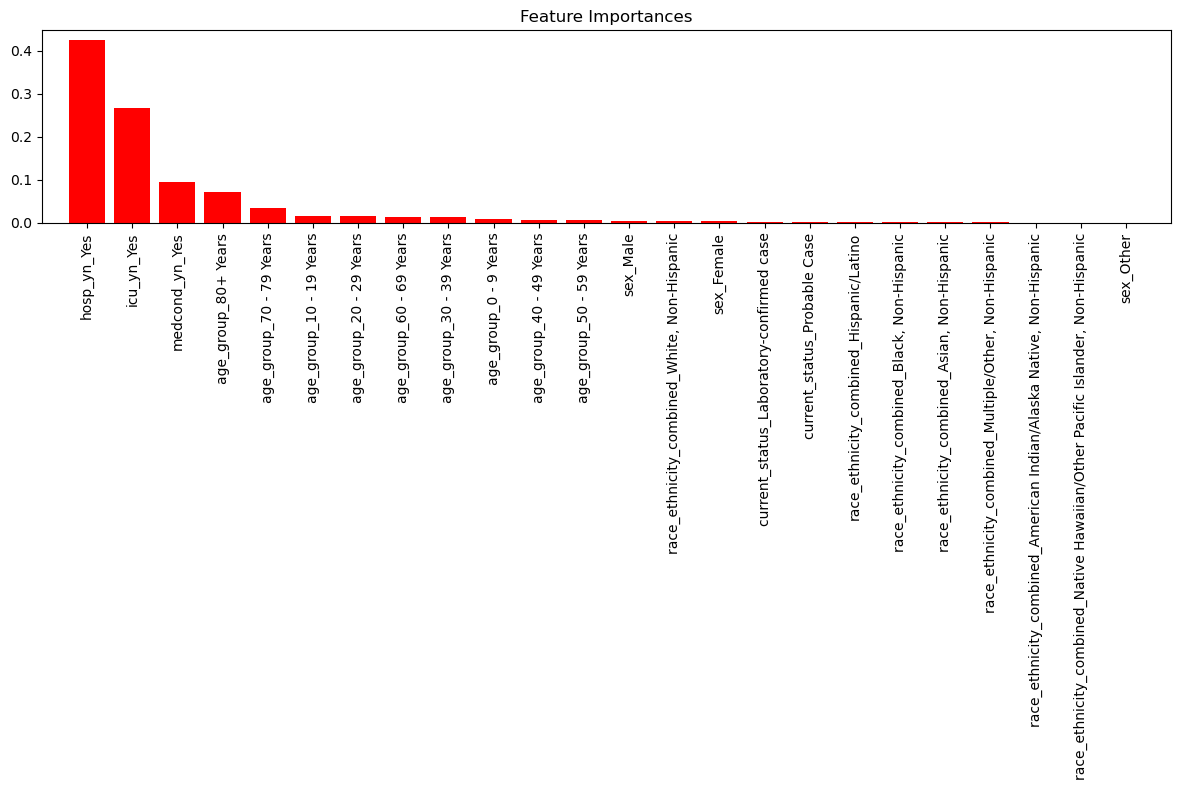

In [59]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'icu_yn_Yes', 'medcond_yn_Yes']
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

##### Re-train the model without hospitalization & ICU admission status

In [85]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [86]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

Testing Accuracy: 0.9612703542913488
ROC-AUC:  0.894173695609284
PR-AUC:  0.2225352466305749


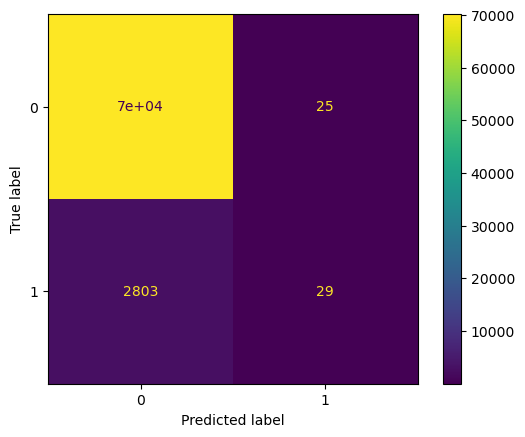

In [88]:
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

rf_classifier.fit(X_train, y_train)
y_pred_test = rf_classifier.predict(X_test)

y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
plot_roc_curve(y_test, y_scores_test)
plot_precision_recall_curve(y_test, y_scores_test)
plot_confusion_matrix(y_test, y_pred_test)

Upon re-training the model without hospitalization & ICU admission status, we notice a severe decrease in PR-AUC indicating that we have more performance when it comes to true positive label classifications.

#### 2. Balance the Class Size

In [74]:
df = pd.read_pickle("./cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encode_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

false_data = df[df['death_yn_Yes'] == 0]  # Majority class
true_data = df[df['death_yn_Yes'] == 1]   # Minority class
undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [76]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)

Testing Accuracy: 0.9098645362973254
ROC-AUC:  0.961505157948599
PR-AUC:  0.9440476509537509


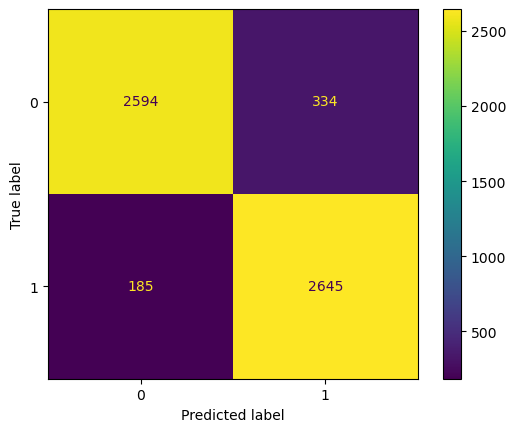

In [80]:
#Initialize the RF model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

#Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
plot_roc_curve(y_test, y_scores_test)
plot_precision_recall_curve(y_test, y_scores_test)
plot_confusion_matrix(y_test, y_pred_test)

Here, we see that our testing accuracy had decreased ever-so-slightly (about 5%) but our ROC_AUC and PR-AUC has increased significantly! Our classifications are now not pre-dominantly true negatives and are better distributed. Despite our decrease in testing accuracy, our model is performing much better than before.

#### 3. Model Tuning

In [83]:
# Define hyperparameters and their respective ranges to consider for the random search
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']}

# Initialize the base model
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with the desired number of iterations and cross-validation folds
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1_weighted'
)

# Perform the RandomizedSearchCV to find the best model
best_rf = random_search.fit(X_train, y_train)

# Best hyperparameters from RandomizedSearchCV
print("Best hyperparameters:\n", best_rf.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameters:
 {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 40, 'class_weight': 'balanced_subsample', 'bootstrap': True}


Testing Accuracy: 0.9100382077110107
ROC-AUC:  0.9628402628936645
PR-AUC:  0.9499563028995839


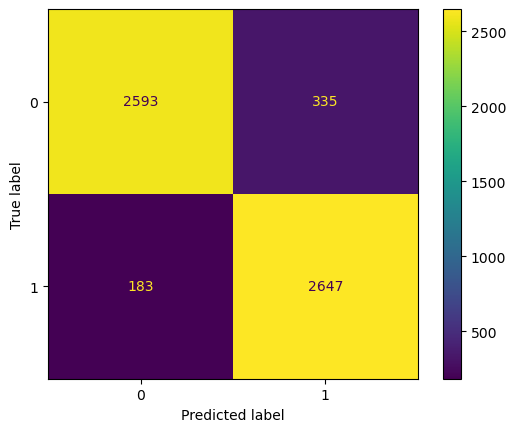

In [84]:
best_rf_model = best_rf.best_estimator_
y_pred_test = best_rf_model.predict(X_test)

y_scores_val = best_rf_model.predict_proba(X_val)[:, 1]
y_scores_test = best_rf_model.predict_proba(X_test)[:, 1]

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
plot_roc_curve(y_test, y_scores_test)
plot_precision_recall_curve(y_test, y_scores_test)
plot_confusion_matrix(y_test, y_pred_test)

Here, we hyperparameter tune our model from before as we saw great performance in the prior section. With the hyperparameter optimization, we observe improved values for testing accuracy, ROC-AUC, and PR-AUC. Overall, this model is the best among our Random Forests.

## Insights and Recommendations

### Logistic Regression

In [95]:
model_names = ['Naive LR', 'LR with customized loss function']
accuracies = [0.9676, 0.9097]
roc_scores = [0.9654, 0.9656]
pr_scores = [0.5348, 0.5970 ]

# Create a DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'ROC AUC': roc_scores,
    'PR AUC': pr_scores
})

In [94]:
results_df

,Model,Accuracy,ROC AUC,PR AUC
0,Naive LR,0.9676,0.9654,0.5348
1,LR with customized loss function,0.9097,0.9656,0.5970



Replacing the original binary cross entropy loss with a customized loss function which takes negative true into account, improves the precision-recall score from 0.53 to 0.59 while remains ROC score. It suggests the model's ability of discriminate between positive and negative class improves. We also observed that the less important metric accuracy dropped a bit (not significantly), which is acceptable because we are prioritizing identifying high death likelihood over overall classification correctness.

In [99]:
model_names = ['LR trained with whole dataset', 'LR trained with smaller dataset', 'LR trained after dominant feature removal']
accuracies = [0.9097, 0.9059, 0.9029]
roc_scores = [0.9656, 0.9617, 0.9477]
pr_scores = [0.5970, 0.9499, 0.9189 ]

# Create a DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'ROC AUC': roc_scores,
    'PR AUC': pr_scores
})

In [100]:
results_df

,Model,Accuracy,ROC AUC,PR AUC
0,LR trained with whole dataset,0.9097,0.9656,0.5970
1,LR trained with smaller dataset,0.9059,0.9617,0.9499
2,LR trained after dominant feature removal,0.9029,0.9477,0.9189



Training the model with even number of class label (~ 28,000 true and 28,000 false) solve the data imbalance at the expense of much less amount of available training data. The precision-recall score improves a lot from 0.59 to 0.95, while ROC and accuracy remains around same. 
Training the model after the most dominant feature `icu_yn` being removed, we observed a very tiny drop in model's performance among 3 metrics, which shows the original model was not relying too much on that feature when making prediction. This indicates the model's great robustness.

After all the experiments, we identify the model with customized loss function trained with even class label dataset as the best performing one, and you will be able to use that model through our [interface](https://cs475project-c17babadc414.herokuapp.com/).

### Random Forest

In [4]:
model_names = ['RF (Original)', 'RF trained w/o hospitalization & ICU admission status', 'RF w/ Balanced Class Size', 'RF w/ Balanced Class Size & 3-Fold Validation']
accuracies = [0.9678, 0.9612, 0.9098, 0.9100]
roc_scores = [0.9637, 0.8941, 0.9615,  0.9628]
pr_scores = [0.5292, 0.2225, 0.9440, 0.9499]

# Create a DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'ROC AUC': roc_scores,
    'PR AUC': pr_scores
})

In [5]:
results_df

,Model,Accuracy,ROC AUC,PR AUC
0,RF (Original),0.9678,0.9637,0.5292
1,RF trained w/o hospitalization & ICU admission...,0.9612,0.8941,0.2225
2,RF w/ Balanced Class Size,0.9098,0.9615,0.9440
3,RF w/ Balanced Class Size & 3-Fold Validation,0.9100,0.9628,0.9499


From the above table, we observed that Random Forest without the hospitalization & ICU admission resulted in a model with comparable testing accuracy but significantly worse pr_scores and slightly worse roc_scores. This indicates that our although our model is able to perform well on the test set, when it comes to our classification that our model fails to perform true positive predictions among all positive predictions.

Next, we went about balancing the class size for Random Forest. Although a slight drop in testing accuracy, the confusion matrix results were much, much better which meant our classification capabilities were much more accurate. Given this, our model is overall better than our baseline model for Random Forest.

Finally, we want to take our Random Forest w/ Balanced Class Size and optimize our hyperparameters where we chose to perform K-Fold Cross Validation with a value of $k=3$ and this resulted in improved performance for our metrics (although miniscule). Overall, our Random Forest best with a balanced class size and next steps could involve different methods of optimizing our Random Forest such as adjusting the number of trees, etc.